In [22]:
import os
import joblib
import random
import gc # <--- PENTING: Garbage Collector untuk bersihkan RAM
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder # Import library baru
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization

In [23]:
# ==========================================
# 1. SETUP & CONFIG
# ==========================================
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Pakai Mixed Precision agar hemat memori GPU/CPU (Optional, aman dihapus jika error)
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
except:
    pass

print(f"✅ System initialized. Python: {os.sys.version.split()[0]}")

✅ System initialized. Python: 3.13.5


In [33]:
# ==========================================
# 2. LOAD DATA (EXPLICIT MAPPING & CONVERT TO NUMPY)
# ==========================================
path_joblib = r"C:\Users\BINTANG PANDU\Downloads\prepared_for_ae (1).joblib"
print(f"📂 Loading: {path_joblib}")

data_dict = joblib.load(path_joblib)
print(f"   Keys loaded: {list(data_dict.keys())}")

# --- MAPPING MANUAL & CONVERT KE NUMPY ARRAY ---
X_train = np.array(data_dict['Xtr_scaled'])
y_train_raw = np.array(data_dict['y_train']).ravel() # <-- Disini y_train_raw dibuat
X_val= np.array(data_dict['Xv_scaled'])
y_val_raw = np.array(data_dict['y_val']).ravel()    # <-- Disini y_val_raw dibuat
X_test= np.array(data_dict['Xte_scaled'])
y_test_raw = np.array(data_dict['y_test']).ravel()  # <-- Disini y_test_raw dibuat

# Hapus dictionary joblib
del data_dict
gc.collect()

print(f"✅ DATA MAPPED CORRECTLY (y_raw created).")

📂 Loading: C:\Users\BINTANG PANDU\Downloads\prepared_for_ae (1).joblib
   Keys loaded: ['Xtr_scaled', 'Xv_scaled', 'Xte_scaled', 'Xtr_benign', 'y_train', 'y_val', 'y_test', 'selected_cols']
✅ DATA MAPPED CORRECTLY (y_raw created).


In [34]:
# ==========================================
# 3. LABEL ENCODING (REVISI: FORCED BINARY CLASSIFICATION)
# ==========================================
print("\n🔄 Performing Label Encoding (String -> Binary Int)...")

# 1. Tentukan label BENIGN
unique_labels = np.unique(y_train_raw)
benign_label = 'BENIGN' 
if benign_label not in unique_labels:
    # Jika tidak ada 'BENIGN', cari label yang paling sering muncul
    benign_label = Counter(y_train_raw).most_common(1)[0][0]
    print(f"   ⚠️ WARNING: 'BENIGN' not found. Using majority class: {benign_label}")

# 2. Lakukan Konversi: BENIGN -> 0, Sisanya -> 1
def convert_to_binary(y_raw, benign_name):
    y_binary = np.zeros_like(y_raw, dtype=np.int8) 
    y_binary[y_raw != benign_name] = 1 
    return y_binary

y_train = convert_to_binary(y_train_raw, benign_label)
y_val = convert_to_binary(y_val_raw, benign_label)
y_test = convert_to_binary(y_test_raw, benign_label)

# 3. Final Check dan Cleaning
print(f"   New Label Distribution (Train): {np.unique(y_train, return_counts=True)}")

# Bersihkan variabel raw
del y_train_raw, y_val_raw, y_test_raw
gc.collect()

print(f"✅ Label Encoding Success. Data siap untuk Binary Classification (0 atau 1).")


🔄 Performing Label Encoding (String -> Binary Int)...
   New Label Distribution (Train): (array([0, 1], dtype=int8), array([1503870,  298114]))
✅ Label Encoding Success. Data siap untuk Binary Classification (0 atau 1).


In [35]:
# --- Constants & Helpers (Diambil dari setup sebelumnya) ---
SEED = 42
initializer = tf.keras.initializers.GlorotUniform(seed=SEED)
alpha = 0.9
T = 2.5

# Fungsi Helper untuk Evaluasi
def evaluasi_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    # Pastikan shape input 1D untuk ROC-AUC
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred_proba = y_pred_proba.flatten() 
    
    print(f"\n{'='*20} {model_name} EVALUATION {'='*20}")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f"🚀 ROC-AUC Score: {auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


🔄 Training Teacher (LightGBM) on Alika's Binary Data...
[LightGBM] [Info] Number of positive: 298114, number of negative: 1503870
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7856
[LightGBM] [Info] Number of data points in the train set: 1801984, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165437 -> initscore=-1.618321
[LightGBM] [Info] Start training from score -1.618321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.0029517
✅ Teacher Trained.


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



==================== Teacher Alika (Binary LGBM) EVALUATION ====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322258
           1       1.00      1.00      1.00     63882

    accuracy                           1.00    386140
   macro avg       1.00      1.00      1.00    386140
weighted avg       1.00      1.00      1.00    386140

🚀 ROC-AUC Score: 1.0000


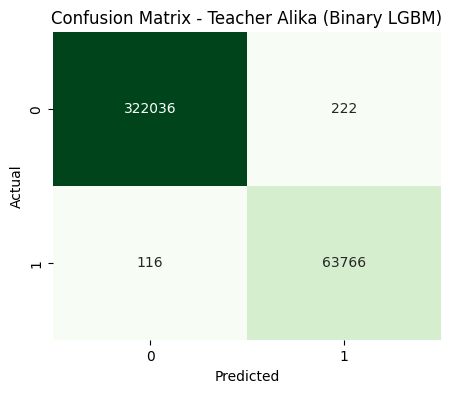

In [37]:
# ==========================================
# 4. TEACHER MODEL: LightGBM (Binary Classification)
# ==========================================
print("\n🔄 Training Teacher (LightGBM) on Alika's Binary Data...")

lgbm = LGBMClassifier(
    n_estimators=500, learning_rate=0.05, random_state=SEED, n_jobs=-1
)

# LightGBM sekarang di-train sebagai BINARY CLASSIFIER
lgbm.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss", 
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

print("✅ Teacher Trained.")

# Evaluasi Teacher
teacher_pred = lgbm.predict(X_test)
teacher_pred_proba = lgbm.predict_proba(X_test)[:, 1] # Ambil probabilitas kelas 1
evaluasi_model(y_test, teacher_pred, teacher_pred_proba, model_name="Teacher Alika (Binary LGBM)")

In [38]:
# ==========================================
# 5. PREPARE DATA FOR TENSORFLOW (Distillation)
# ==========================================
print("\n🧪 Preparing Knowledge Distillation...")

# Generate Soft Labels
teacher_probs_train = lgbm.predict_proba(X_train)[:,1].astype("float32")
teacher_probs_val   = lgbm.predict_proba(X_val)[:,1].astype("float32")

# Konversi X & y ke format float32 NumPy untuk TF
# (Variabel ini sudah ada di memori dari langkah sebelumnya, tapi kita pastikan tipenya)
X_train_np = X_train.astype("float32")
X_val_np   = X_val.astype("float32")
X_test_np  = X_test.astype("float32")
y_train_np = y_train.astype("float32") 
y_val_np   = y_val.astype("float32")
y_test_np  = y_test.astype("float32")

# Cleaning RAM (Hapus versi LightGBM yang sudah tidak diperlukan)
del X_train, y_train, X_val, y_val, X_test, y_test
gc.collect()

# Distillation Targets (Soft Labels + Hard Labels)
t_train = teacher_probs_train ** (1/T)
t_val   = teacher_probs_val   ** (1/T)

y_train_distill = alpha * t_train + (1 - alpha) * y_train_np
y_val_distill   = alpha * t_val   + (1 - alpha) * y_val_np

del teacher_probs_train, teacher_probs_val, t_train, t_val
gc.collect()

# Hitung Class Weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weight_dict = dict(enumerate(class_weights))
print(f"⚖️ Class Weights: {class_weight_dict}")


🧪 Preparing Knowledge Distillation...


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


⚖️ Class Weights: {0: np.float64(0.5991156150465133), 1: np.float64(3.0223069027284866)}


In [39]:
# ==========================================
# 6. STUDENT MODEL (TRAINING)
# ==========================================
print("\n🏗️ Building Student Model...")

# Model FNN: Menggunakan arsitektur sukses sebelumnya (Tanpa Normalization Layer)
student = Sequential([
    Dense(512, activation='relu', kernel_initializer=initializer, input_shape=(X_train_np.shape[1],)),
    Dropout(0.2, seed=SEED),
    Dense(256, activation='relu', kernel_initializer=initializer),
    Dropout(0.2, seed=SEED),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['AUC']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1),
]

print("🔄 Training Student...")
history = student.fit(
    X_train_np, y_train_distill,
    validation_data=(X_val_np, y_val_distill),
    epochs=50,
    batch_size=4096,
    verbose=2,
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weight_dict
)


🏗️ Building Student Model...


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔄 Training Student...
Epoch 1/50
440/440 - 64s - 145ms/step - AUC: 0.7385 - loss: 0.0621 - val_AUC: 0.7553 - val_loss: 0.0564 - learning_rate: 1.0000e-03
Epoch 2/50
440/440 - 61s - 139ms/step - AUC: 0.7579 - loss: 0.0424 - val_AUC: 0.7855 - val_loss: 0.0562 - learning_rate: 1.0000e-03
Epoch 3/50
440/440 - 61s - 140ms/step - AUC: 0.7728 - loss: 0.0412 - val_AUC: 0.7851 - val_loss: 0.0554 - learning_rate: 1.0000e-03
Epoch 4/50
440/440 - 63s - 144ms/step - AUC: 0.7853 - loss: 0.0406 - val_AUC: 0.7665 - val_loss: 0.0553 - learning_rate: 1.0000e-03
Epoch 5/50
440/440 - 80s - 182ms/step - AUC: 0.7877 - loss: 0.0402 - val_AUC: 0.7458 - val_loss: 0.0552 - learning_rate: 1.0000e-03
Epoch 6/50
440/440 - 81s - 185ms/step - AUC: 0.7894 - loss: 0.0401 - val_AUC: 0.7478 - val_loss: 0.0545 - learning_rate: 1.0000e-03
Epoch 7/50
440/440 - 67s - 152ms/step - AUC: 0.7896 - loss: 0.0399 - val_AUC: 0.7614 - val_loss: 0.0546 - learning_rate: 1.0000e-03
Epoch 8/50
440/440 - 67s - 152ms/step - AUC: 0.7923 - 


🔎 Evaluating Student Alika...
12067/12067 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step

==================== Student Alika (Final) EVALUATION ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    322258
         1.0       0.99      1.00      0.99     63882

    accuracy                           1.00    386140
   macro avg       0.99      1.00      1.00    386140
weighted avg       1.00      1.00      1.00    386140

🚀 ROC-AUC Score: 1.0000


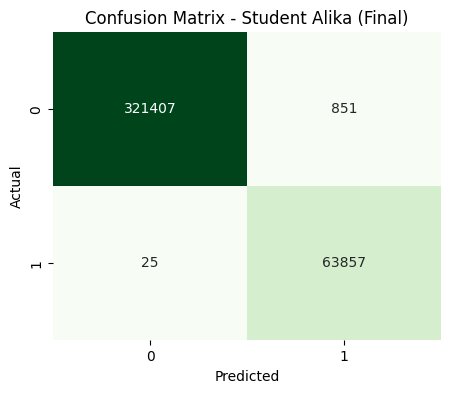

In [40]:
# ==========================================
# 7. EVALUASI & SAVE TFLITE
# ==========================================
print("\n🔎 Evaluating Student Alika...")
student_pred_proba = student.predict(X_test_np).flatten()
student_pred = (student_pred_proba > 0.5).astype(int)

# Gunakan y_test_np (float32) untuk evaluasi
evaluasi_model(y_test_np, student_pred, student_pred_proba, model_name="Student Alika (Final)")

In [46]:
import tensorflow as tf
import joblib

# ==========================================
# PERBAIKAN ULTIMATE: MENGGUNAKAN FLEX OPS (SELECT_TF_OPS)
# ==========================================
print("\n🔥 PERBAIKAN ULTIMATE: Menggunakan FLEX OPS (SELECT_TF_OPS)...")
print("   Ini akan memastikan kompatibilitas, meskipun file .tflite akan lebih besar.")

# 1. Reset Policy (Untuk menghindari konflik)
try:
    tf.keras.mixed_precision.set_global_policy('float32')
except:
    pass

# 2. Inisialisasi Converter
converter = tf.lite.TFLiteConverter.from_keras_model(student)

# 3. KUNCI FIX: Aktifkan FLEX OPS
# Kita izinkan TFLite menggunakan operasi penuh TensorFlow jika menemukan operasi yang sulit.
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS    # Opsi yang akan mengatasi error float16
]

# (Kita hapus optimization lain untuk fokus pada kompatibilitas)

try:
    tflite_model = converter.convert()
    
    tflite_filename = "EA.tflite"

    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print(f"✅ KONVERSI AKHIR BERHASIL! FILE SIAP: {tflite_filename}")
    print("\nProses model Alika sudah selesai. Sekarang Anda memiliki dua file .tflite yang siap untuk perbandingan: Farrel dan Alika.")
    
except Exception as e:
    print(f"❌ ERROR KRITIS: Konversi gagal, bahkan dengan FLEX OPS. Ada masalah instalasi TF/TFLite yang lebih dalam.")


🔥 PERBAIKAN ULTIMATE: Menggunakan FLEX OPS (SELECT_TF_OPS)...
   Ini akan memastikan kompatibilitas, meskipun file .tflite akan lebih besar.
INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmp2e86cgyb\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmp2e86cgyb\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmp2e86cgyb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float16, name=None)
Captures:
  2225272048912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272049488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272053136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272059664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272060048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272059280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272049296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2225272058896: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ KONVERSI AKHIR BERHASIL! FILE SIAP: EA.tflite

Proses model Alika sudah selesai. Sekarang Anda memiliki dua file .tflite yang siap untuk perbanding